In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#### Function

In [2]:
def datetime_break(df):
    df['time'] = pd.to_datetime(df['time'])
    df['date'] = df['time'].dt.date
    df['quarter'] = df['time'].dt.quarter
    df['month'] = df['time'].dt.month
    df['week_number'] = df['time'].dt.isocalendar().week
    df['day'] = df['time'].dt.isocalendar().week
    df['time_of_day'] = df['time'].dt.time
    df['hour'] = df['time'].dt.hour
    df['minute'] = df['time'].dt.minute
    df.drop('time', axis = 1, inplace = True)

#### Data loading & treatment

In [3]:
# path way for the data set
train_path = '../input/tabular-playground-series-mar-2022/train.csv'
test_path = '../input/tabular-playground-series-mar-2022/test.csv'

# load the data and seperate for train & test set
x_train = pd.read_csv(train_path, index_col = 0).drop_duplicates()
x_test = pd.read_csv(test_path,index_col = 0).drop_duplicates()
y_train = x_train.pop('congestion').to_frame()

# break the time column and drop it
datetime_break(x_train)
datetime_break(x_test)

# ordianl labeling for direction column
x_train_ohe = pd.get_dummies(x_train['direction'])
x_toname = {x:y for x,y in enumerate(x_train_ohe.columns)}
x_toint = {y:x for x,y in enumerate(x_train_ohe.columns)}
x_train['direction_num'] = x_train['direction'].map(x_toint)
x_test['direction_num'] = x_test['direction'].map(x_toint)
x_train.drop(['direction','date','time_of_day'], axis = 1, inplace = True)
x_test.drop(['direction','date','time_of_day'], axis = 1, inplace = True)

In [4]:
# check with the missing value
print(f'Missing value in training set: \n{x_train.isna().sum()}')
print(f'Missing value in testing set: \n{x_test.isna().sum()}')

Missing value in training set: 
x                0
y                0
quarter          0
month            0
week_number      0
day              0
hour             0
minute           0
direction_num    0
dtype: int64
Missing value in testing set: 
x                0
y                0
quarter          0
month            0
week_number      0
day              0
hour             0
minute           0
direction_num    0
dtype: int64


In [5]:
# preview for the testing set
x_train.head()

,x,y,quarter,month,week_number,day,hour,minute,direction_num
row_id,,,,,,,,,
0,0,0,2,4,14,14,0,0,0
1,0,0,2,4,14,14,0,0,1
2,0,0,2,4,14,14,0,0,4
3,0,1,2,4,14,14,0,0,0
4,0,1,2,4,14,14,0,0,1


In [6]:
# preview for the testing set
x_test.head()

,x,y,quarter,month,week_number,day,hour,minute,direction_num
row_id,,,,,,,,,
848835,0,0,3,9,40,40,12,0,0
848836,0,0,3,9,40,40,12,0,1
848837,0,0,3,9,40,40,12,0,4
848838,0,1,3,9,40,40,12,0,0
848839,0,1,3,9,40,40,12,0,1


#### Balanced label check for the x & y coordinate

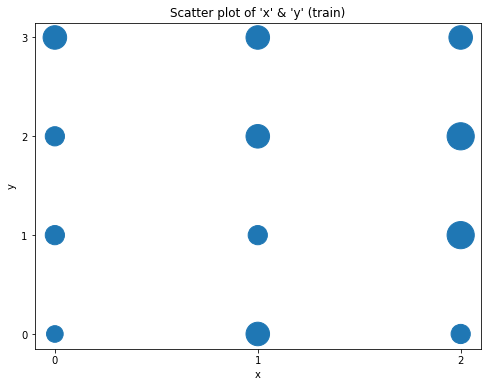

In [7]:
# scatter plot of column 'x' & 'y' in train set
x = 'x'
y = 'y'
df_counts_train = x_train.groupby([x, y]).size().reset_index()
df_counts_train.columns.values[df_counts_train.columns == 0] = 'count'

n_sc = 500 # scale constant
scale = n_sc * df_counts_train['count'].size
size = df_counts_train['count'] / df_counts_train['count'].sum() * scale

fig,ax = plt.subplots(figsize=(8,6))
ax.scatter(x, y, size, data = df_counts_train, zorder = 2)
ax.set_title("Scatter plot of 'x' & 'y' (train)")
ax.set_xlabel(x)
ax.set_ylabel(y)
ax = plt.xticks([0,1,2])
ax = plt.yticks([0,1,2,3])

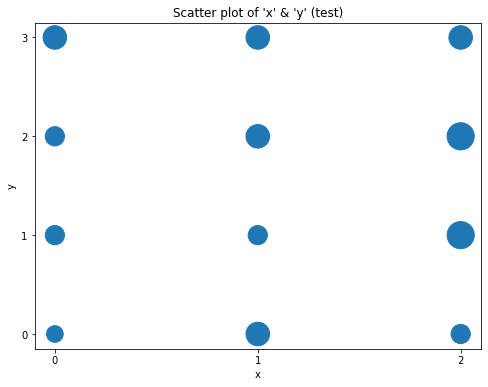

In [8]:
# scatter plot of column 'x' & 'y' in test set
x = 'x'
y = 'y'
df_counts_test = x_test.groupby([x, y]).size().reset_index()
df_counts_test.columns.values[df_counts_test.columns == 0] = 'count'

n_sc = 500 # scale constant
scale = n_sc * df_counts_test['count'].size
size = df_counts_test['count'] / df_counts_test['count'].sum() * scale

fig,ax = plt.subplots(figsize=(8,6))
ax.scatter(x, y, size, data = df_counts_test, zorder = 2)
ax.set_title("Scatter plot of 'x' & 'y' (test)")
ax.set_xlabel(x)
ax.set_ylabel(y)
ax = plt.xticks([0,1,2])
ax = plt.yticks([0,1,2,3])

In [9]:
# compare the sample distribution for both train & test set
df_counts_train['count'] = df_counts_train['count'] / df_counts_train['count'].sum()
df_counts_test['count'] = df_counts_test['count'] / df_counts_test['count'].sum()

df_diff = pd.DataFrame()
df_diff['diff'] = df_counts_train['count']/ df_counts_test['count']
df_diff['diff'].unique()

array([1.])

After the calculation & plot, the count of x & y coordinate in both train set & test set is the same.

#### KNN with optimal K value

In [10]:
from tqdm import tqdm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

test_size = 0.25
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size = test_size)

mean_abs_error = []
mean_squ_error = []
r2 = []

for i in range(1,20):
    knn = KNeighborsRegressor(n_neighbors = i)
    knn.fit(X_train, Y_train)
    pred_i = knn.predict(X_test)
    mean_abs_error.append(mean_absolute_error(Y_test, pred_i))
    mean_squ_error.append(mean_squared_error(Y_test, pred_i))
    r2.append(r2_score(Y_test, pred_i))

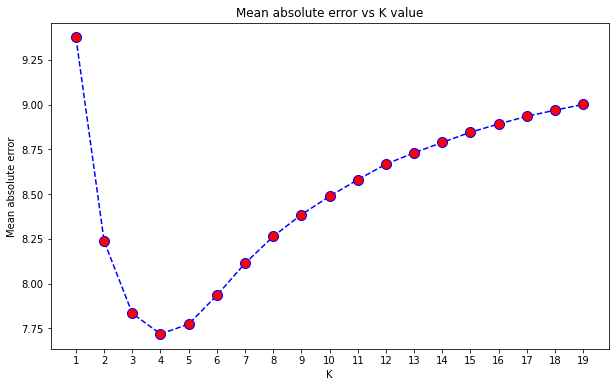

In [11]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20), mean_abs_error, color = 'blue', linestyle= 'dashed', marker='o',
        markerfacecolor='red', markersize= 10)
plt.title('Mean absolute error vs K value')
plt.xlabel('K')
plt.ylabel('Mean absolute error')
ax = plt.xticks(range(1,20))

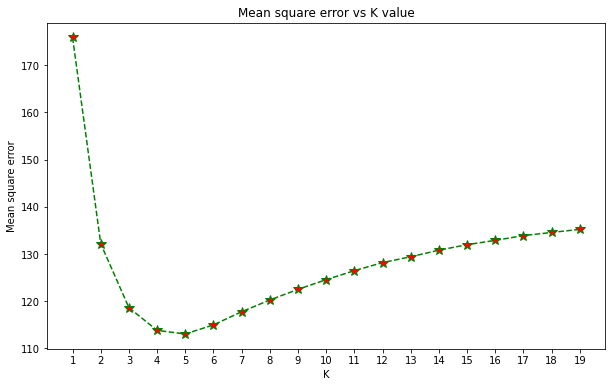

In [12]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20), mean_squ_error, color = 'green', linestyle = 'dashed', marker = '*', 
         markerfacecolor = 'red', markersize= 10)
plt.title('Mean square error vs K value')
plt.xlabel('K')
plt.ylabel('Mean square error')
ax = plt.xticks(range(1,20))

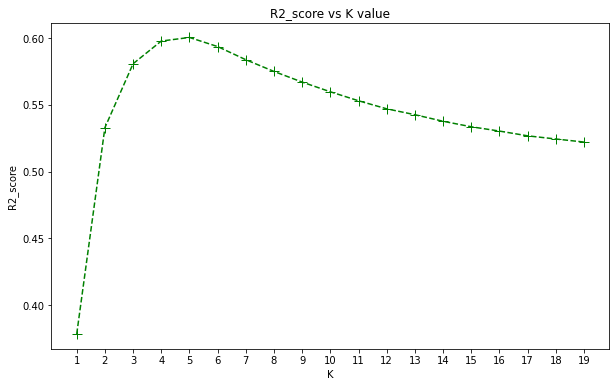

In [13]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20), r2, color = 'green', linestyle = 'dashed', marker = '+', markerfacecolor = 'red', markersize= 10)
plt.title('R2_score vs K value')
plt.xlabel('K')
plt.ylabel('R2_score')
ax = plt.xticks(range(1,20))

Best k-value for KNN: 4 or 5

#### PCA part

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# standardize the data before PCA
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_train)

# build PCA model with None n_components (return same amount PC as features)
pca = PCA(n_components = None)
L = pca.fit_transform(x_scaled)

In [15]:
# round up the target with 10 to prevent chaos in visualization
y_rounded = y_train.copy()
y_rounded['congestion'] = np.round(y_rounded['congestion'], -1)

In [16]:
# check the explanied variance ratio
print(pca.explained_variance_ratio_ * 100);

[4.21487867e+01 1.19871970e+01 1.16164533e+01 1.11118231e+01
 1.11102447e+01 9.72968307e+00 2.08920664e+00 2.06605561e-01
 1.00111862e-31]


First two components captured around 64% of variability. Let's plot out and check is there any cluster can be found.

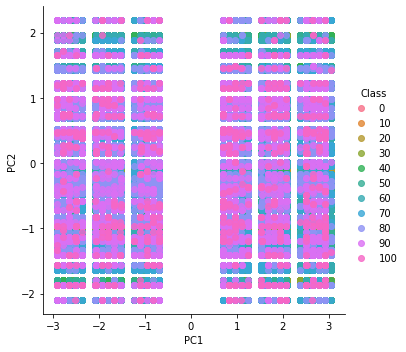

In [17]:
# plot out the PCA graph
def pca_scatter(pca, standardised_value, classifs):
    foo = pca.transform(standardised_value)
    bar = pd.DataFrame(zip(foo[:,0], foo[:,1], classifs), columns = ['PC1', 'PC2','Class'])
    sns.lmplot(data = bar, x = 'PC1', y = 'PC2', hue = 'Class', fit_reg = False)
    
pca_scatter(pca, x_scaled, y_rounded['congestion'])

There is no obvious cluster but there is a pattern. Let's check the feature with high co-efficient.

In [18]:
# absolute all the feature coefficient
pca_components = abs(pca.components_)
print('Top 3 most import features in each component:')
# get the most highest absolute coefficient in all PC
for row in range(pca_components.shape[0]):
    temp = np.argpartition(-(pca_components[row]),3)
    
    indices = temp[np.argsort((-pca_components[row])[temp])][:3]
    
    print(f'Component {row}: {x_train.columns[indices].to_list()}')

Top 3 most import features in each component:
Component 0: ['week_number', 'day', 'month']
Component 1: ['direction_num', 'x', 'y']
Component 2: ['y', 'x', 'direction_num']
Component 3: ['minute', 'hour', 'quarter']
Component 4: ['hour', 'minute', 'quarter']
Component 5: ['direction_num', 'x', 'y']
Component 6: ['quarter', 'week_number', 'day']
Component 7: ['month', 'week_number', 'day']
Component 8: ['day', 'week_number', 'month']


Try using the reduced Data to train and predict the result

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

test_size = 0.25
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size = test_size)

# build up the pipeline for data input & prediction
_sc = StandardScaler()
_pca = PCA(n_components = None)
_model = KNeighborsRegressor(n_neighbors = 5)

pipe = Pipeline([
    ('std_scaler', _sc),
    ('pca', _pca),
    ('knn_5n', _model)
])

# fit split data and check with the metrics
pipe.fit(X_train.values, Y_train.values)
pred_i = pipe.predict(X_test.values)
print(f'MAE : {mean_absolute_error(Y_test, pred_i)}')
print(f'MSE : {mean_squared_error(Y_test, pred_i)}')
print(f'R2  : {r2_score(Y_test, pred_i)}')

MAE : 7.338236361323036
MSE : 104.78662130258378
R2  : 0.6290741405068206


In [20]:
# get the weight graph of k-Neighbors for points in 'x' 0 / 1 to check with any pattern
A = _model.kneighbors_graph(X_test[X_test['x'] == 0].values, n_neighbors = 5)
B = _model.kneighbors_graph(X_test[X_test['x'] == 1].values, n_neighbors = 5)

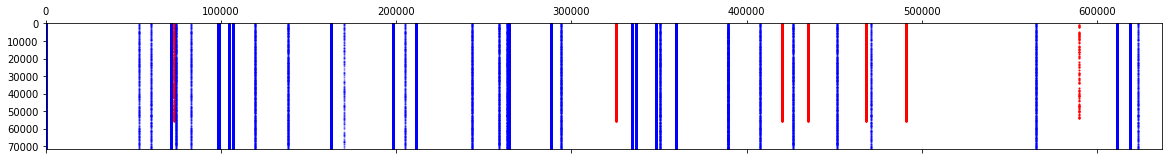

In [21]:
# visualize the pattern and check any findings
plt.figure(figsize= (20,16))
plt.spy(A, c = 'red', markersize = 1)
plt.spy(B, c = 'blue', markersize = 1, alpha = 0.2)

Performance is not bad and try to predict with the test set and submit the result

In [22]:
# predict the result with the pipe built
pred_final3 = pipe.predict(x_test)
# output the result as the submission template
knn_result = pd.DataFrame()
knn_result['row_id'] = x_test.index
knn_result['congestion'] = pred_final3
knn_result.to_csv('knn_submission3.csv', index = False)

After the submission, the score was decreased from 6.029 to 5.503. 

Dimension reduction is worked in the performance improvement.

Train_test_split also provided better MAE instead of using the whole training set.

#### UMAP

Let's using UMAP and plot it out for visualization.

In [23]:
import umap
# build the UMAP reducer
reducer = umap.UMAP()
# fit the data
embedding = reducer.fit_transform(x_train,y_rounded['congestion'])

Let's plot it with the rounded group data again.

Text(0.5, 1.0, 'Visualizating the training data with UMAP')

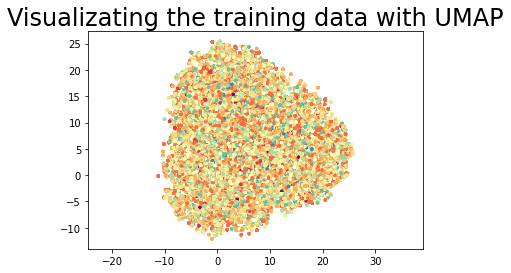

In [24]:
plt.scatter(reducer.embedding_[:,0], reducer.embedding_[:,1], s = 5, c = y_rounded['congestion'], cmap = 'Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.title("Visualizating the training data with UMAP", fontsize = 24)

Seems it is not useful to use UMAP and we will work on PCA as previous findings.

#### Cut off date with PCA

As timeseries data, the training set should be started from June instead of the start from April since the closest data may have similar information due to the weather/ travel peak season. The information for June and April may be different. It's aimed to reduce the bias and make sure the training set and testing set got similar data distribution. Let's check the MAE was improved or not.

In [25]:
# cutoff the month from August for getting related information
x_smaller_train = x_train[x_train['month'] >= 6]
y_smaller_train = y_train.iloc[x_smaller_train.index]

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# build up the pipeline for data input & prediction

test_size = 0.25
X_train, X_test, Y_train, Y_test = train_test_split(x_smaller_train, y_smaller_train, test_size = test_size)

_sc = StandardScaler()
_pca = PCA(n_components = None)
_model = KNeighborsRegressor(n_neighbors = 5)

pipe = Pipeline([
    ('std_scaler', _sc),
    ('pca', _pca),
    ('knn_5n', _model)
])

# fit split data and check with the metrics
pipe.fit(X_train.values, Y_train.values)
pred_i = pipe.predict(X_test.values)
print(f'MAE : {mean_absolute_error(Y_test, pred_i)}')
print(f'MSE : {mean_squared_error(Y_test, pred_i)}')
print(f'R2  : {r2_score(Y_test, pred_i)}')
pred_distribution = pipe.predict(x_test.values)

MAE : 7.40137492115465
MSE : 106.23866221589097
R2  : 0.6263734620920778


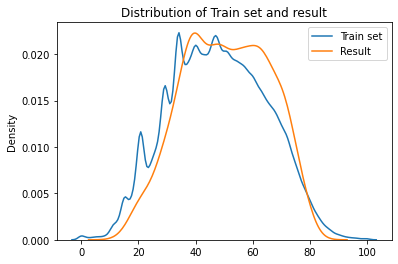

In [27]:
# Check the distribution for both training set & predicted result
ax = sns.distplot(y_train, hist = False, label = 'Train set')
ax = sns.distplot(pred_distribution, hist = False, label = 'Result')
plt.title('Distribution of Train set and result')
plt.legend()
plt.show()

There is a different for 60 - 80 congestion and the time cutoff didn't improve the performance much.

#### KNN hyperparameter tuning

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# List the hyperparameters want to tune
leaf_size = list(range(1,50))
n_neighbors = [4, 5]
p = [1,2]

hyperparameters = dict(leaf_size = leaf_size, n_neighbors = n_neighbors, p = p)

# Split the training set into train & test set for training
test_size = 0.25
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size = test_size)
# build up the pipeline for data input & prediction
_sc = StandardScaler()
_pca = PCA(n_components = None)
_model = KNeighborsRegressor()
_clf = GridSearchCV(_model, hyperparameters, cv = 10)

pipe = Pipeline([
    ('std_scaler', _sc),
    ('pca', _pca),
    ('clf', _clf)
])

best_model = pipe.fit(X_train, Y_train)

In [29]:
print(f'Best leaf size: {_clf.best_estimator_.get_params()["leaf_size"]}')
print(f'Best p: {_clf.best_estimator_.get_params()["p"]}')
print(f'Best n_neighbors: {_clf.best_estimator_.get_params()["n_neighbors"]}')

Best leaf size: 3
Best p: 1
Best n_neighbors: 5


We finally using these best hyperparameter & PCA to predict our final submission.

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# build up the pipeline for data input & prediction

test_size = 0.25
X_train, X_test, Y_train, Y_test = train_test_split(x_smaller_train, y_smaller_train, test_size = test_size)

_sc = StandardScaler()
_pca = PCA(n_components = None)
_model = KNeighborsRegressor(n_neighbors = 5, leaf_size = 35, p = 2)

pipe = Pipeline([
    ('std_scaler', _sc),
    ('pca', _pca),
    ('knn', _model)
])

# fit split data and check with the metrics
pipe.fit(X_train.values, Y_train.values)
pred_i = pipe.predict(X_test.values)
print(f'MAE : {mean_absolute_error(Y_test, pred_i)}')
print(f'MSE : {mean_squared_error(Y_test, pred_i)}')
print(f'R2  : {r2_score(Y_test, pred_i)}')
pred_final = pipe.predict(x_test.values)

MAE : 7.393822776915499
MSE : 105.65923358776465
R2  : 0.6288802968123728


In [31]:
# output the result as the submission template
knn_result = pd.DataFrame()
knn_result['row_id'] = x_test.index
knn_result['congestion'] = pred_final
knn_result.to_csv('knn_submission.csv', index = False)